# Sensor Fusion

In [1]:
import os

import gpflow as gpf
import numpy as np
import tensorflow as tf

from tsipy.correction import SignalGenerator
from tsipy.fusion import SVGPModel, LocalGPModel
from tsipy.fusion.kernels import MultiWhiteKernel
from tsipy.fusion.utils import (
    build_and_concat_label_mask,
    build_and_concat_label_mask_output,
)
from tsipy.utils import (
    make_dir,
    plot_signals,
    plot_signals_and_confidence,
    pprint,
    pprint_block,
    sort_inputs,
)

## Parameters

In [2]:
random_seed = 0
fusion_model = "localgp"
normalization = True
clipping = True
num_inducing_pts = 100
max_iter = 1000
pred_window_width = 0.2
fit_window_width = 0.6

## Generate Dataset

In [3]:
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Generate Brownian motion signal
signal_generator = SignalGenerator(add_degradation=False)

t_a, a = signal_generator["a"]
t_b, b = signal_generator["b"]

pprint("Signal", level=0)
pprint("- t_a", t_a.shape, level=1)
pprint("- a", a.shape, level=1)

pprint("Signal", level=0)
pprint("- t_b", t_b.shape, level=1)
pprint("- b", b.shape, level=1)

Signal                                            
    - t_a                                         (90002,)
    - a                                           (90002,)
Signal                                            
    - t_b                                         (20127,)
    - b                                           (20127,)


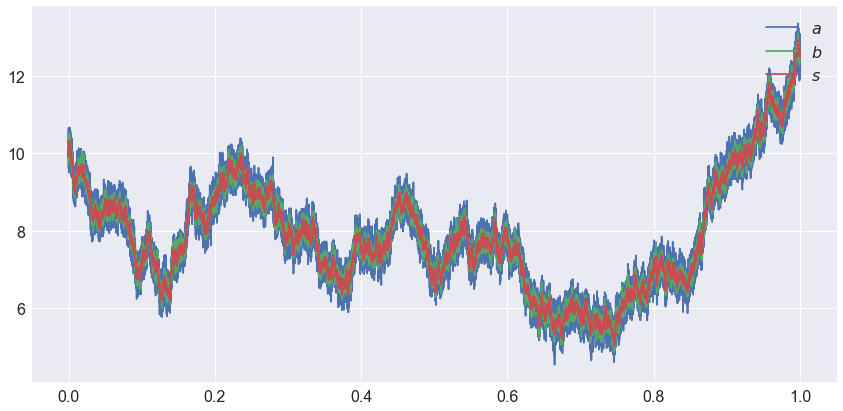

In [4]:
_ = plot_signals(
    [
        (t_a, a, "$a$", {}),
        (t_b, b, "$b$", {}),
        (signal_generator.x, signal_generator.y, "$s$", {}),
    ],
    legend="upper right",
)

## Sensor Fusion

In [5]:
gpf.config.set_default_float(np.float64)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

t_a = build_and_concat_label_mask(t_a, label=1)
t_b = build_and_concat_label_mask(t_b, label=2)
t_out = build_and_concat_label_mask_output(signal_generator.x)

# Concatenate signals and sort by x[:, 0]
t = np.vstack((t_a, t_b))
s = np.reshape(np.hstack((a, b)), newshape=(-1, 1))
t, s = sort_inputs(t, s, sort_axis=0)

pprint("Signals", level=0)
pprint("- t", t.shape, level=1)
pprint("- s", s.shape, level=1)

Signals                                           
    - t                                           (110129, 2)
    - s                                           (110129, 1)


## Covariance Function

In [10]:
# Signal kernel
matern_kernel = gpf.kernels.Matern12(active_dims=[0])  # Kernel for time dimension

# Noise kernel
white_kernel = MultiWhiteKernel(
    labels=(1, 2), active_dims=[1]
)  # Kernel for sensor dimension

# Kernel composite
kernel = matern_kernel + white_kernel

In [11]:
if fusion_model == "localgp":
    local_model = SVGPModel(
        kernel=kernel,
        num_inducing_pts=num_inducing_pts,
    )
    model = LocalGPModel(
        model=local_model,
        pred_window_width=pred_window_width,
        fit_window_width=fit_window_width,
        normalization=normalization,
        clipping=clipping,
    )
else:
    model = SVGPModel(  # type: ignore
        kernel=kernel,
        num_inducing_pts=num_inducing_pts,
        normalization=normalization,
        clipping=clipping,
    )

# Train
model.fit(t, s, max_iter=max_iter, x_val=t_out, n_evals=5, verbose=True)

# Predict
s_out_mean, s_out_std = model(t_out)

pprint("\nOutput Signals", level=0)
pprint("- t_out", t_out.shape, level=1)
pprint("- s_out_mean", s_out_mean.shape, level=1)
pprint("- s_out_std", s_out_std.shape, level=1)

Window
    - Prediction:                                 -inf,    0.200
    - Training:                                   0.000,    0.400
    - Data indices:                               0,    44123
    - x, y:                                       (44124, 2), (44124, 1)
    - n_ind_pts/time_unit                         167.500
    - Step      1/1000:                           -102861.436
    - Step    200/1000:                           -60166.646
    - Step    400/1000:                           -48834.761
    - Step    600/1000:                           -36544.229
    - Step    800/1000:                           -25922.179
    - Step   1000/1000:                           -17701.639
Window
    - Prediction:                                 0.200,    0.400
    - Training:                                   0.000,    0.600
    - Data indices:                               0,    66134
    - x, y:                                       (66135, 2), (66135, 1)
    - n_ind_pts/time_unit   

## Results

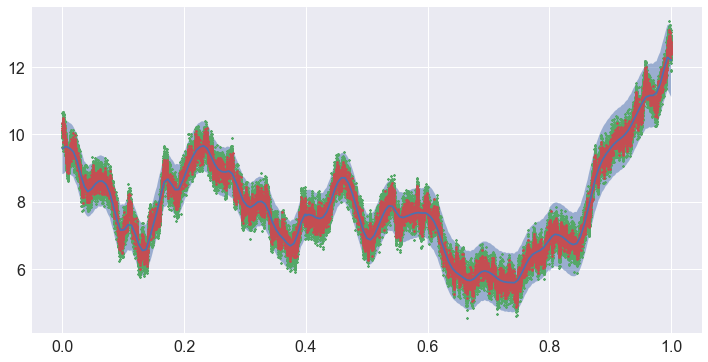

In [12]:
fig, ax = plot_signals_and_confidence(
    [(t_out[:, 0], s_out_mean, s_out_std, fusion_model)],
)
ax.scatter(
    t_a[:, 0],
    a,
    label="$a$",
    s=3,
)
_ = ax.scatter(
    t_b[:, 0],
    b,
    label="$b$",
    s=3,
)

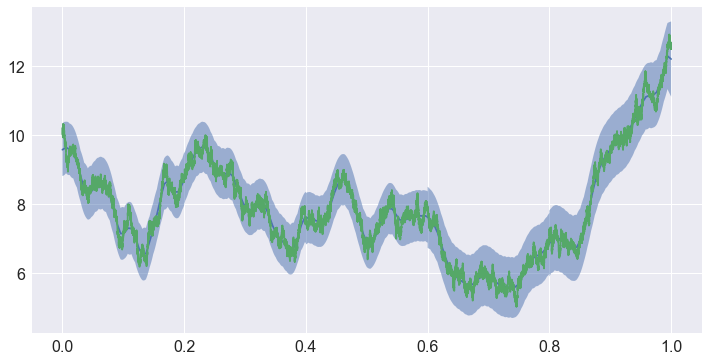

In [13]:
fig, ax = plot_signals_and_confidence(
    [(t_out[:, 0], s_out_mean, s_out_std, fusion_model)],
)
_ = ax.plot(signal_generator.x, signal_generator.y, label="$s$")

### Training

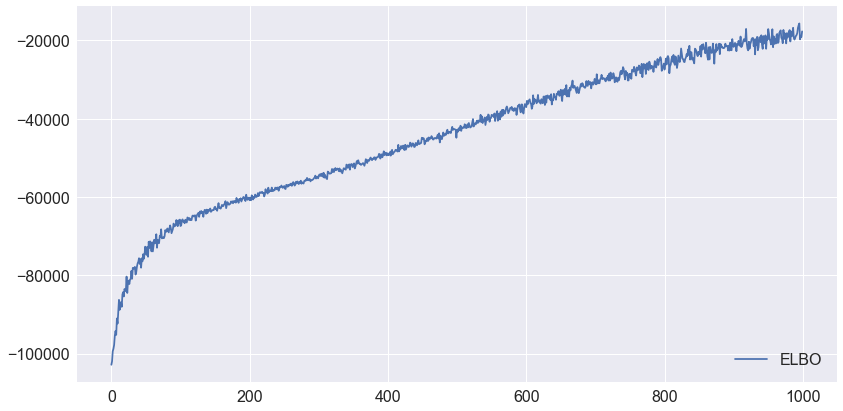

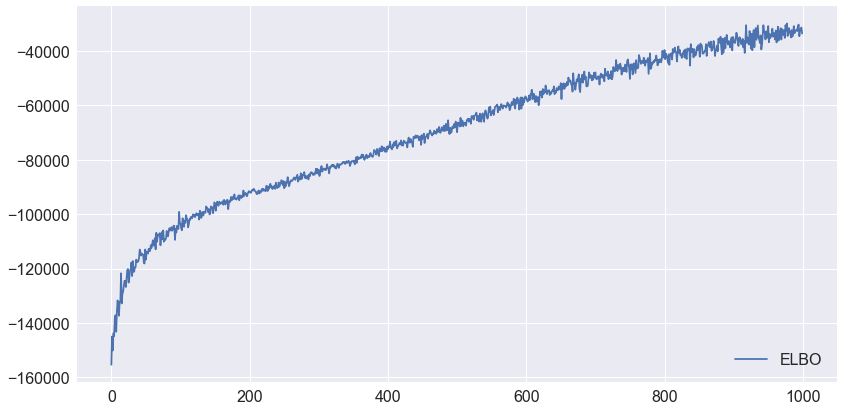

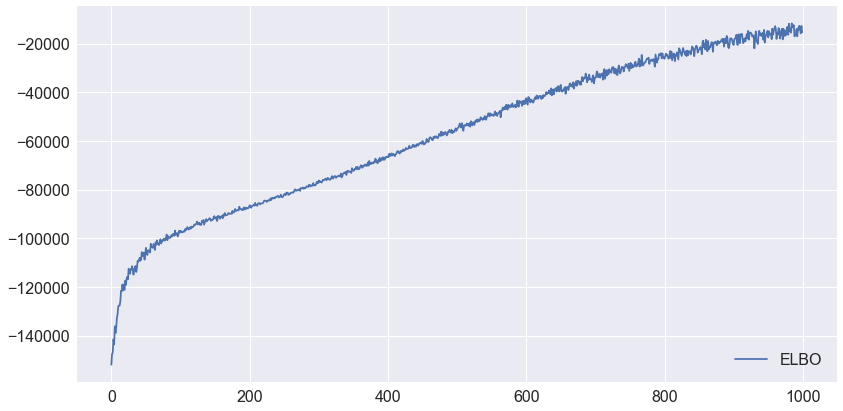

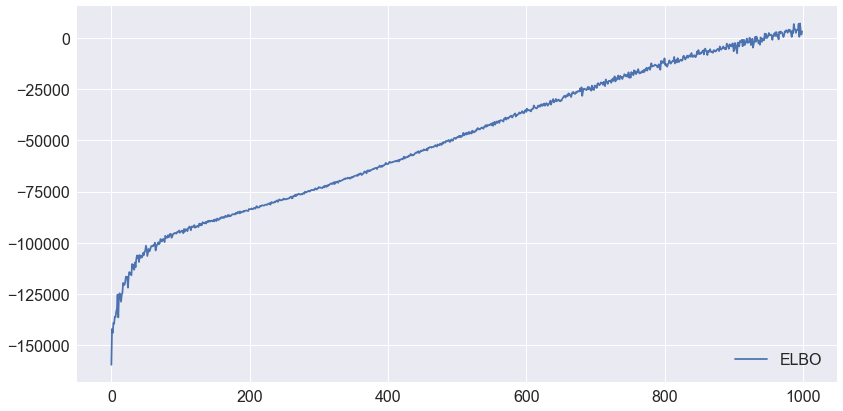

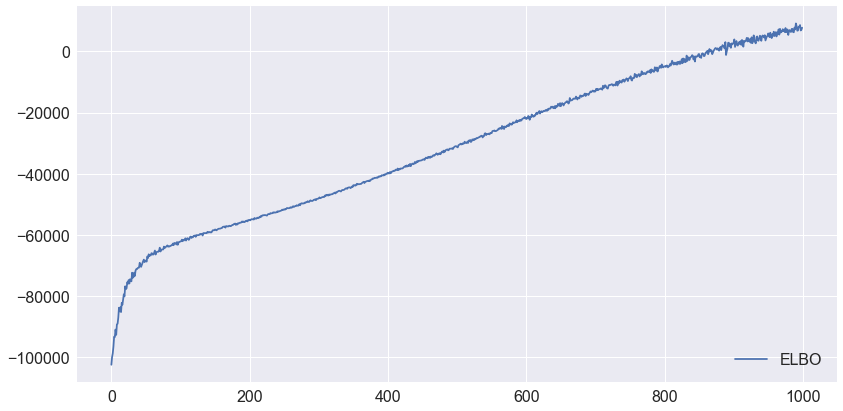

In [14]:
if fusion_model == "localgp":
    for i, window in enumerate(model.windows):
        elbo = window.model.iter_elbo
        plot_signals(
            [(np.arange(elbo.size), elbo, r"ELBO", {})],
            legend="lower right",
        )
else:
    elbo = model.iter_elbo  # type: ignore
    plot_signals(
        [(np.arange(elbo.size), elbo, r"ELBO", {})],
        legend="lower right",
    )